Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,34 mins 59 secs
H2O_cluster_timezone:,America/Toronto
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.1
H2O_cluster_version_age:,1 month and 11 days
H2O_cluster_name:,H2O_from_python_sunnygao_lq939i
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.464 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
01:24:03.708: Project: AutoML_3_20240425_12403
01:24:03.708: 5-fold cross-validation will be used.
01:24:03.709: Setting stopping tolerance adaptively based on the training frame: 0.028676966733820218
01:24:03.709: Build control seed: 1
01:24:03.710: training frame: Frame key: AutoML_3_20240425_12403_training_py_15_sid_9c72    cols: 20    rows: 1216  chunks: 1    size: 206048  checksum: 540579767905324928
01:24:03.711: validation frame: NULL
01:24:03.711: leaderboard frame: NULL
01:24:03.711: blending frame: NULL
01:24:03.711: response column: Order Item Quantity
01:24:03.711: fold column: null
01:24:03.711: weights column: null
01:24:03.712: Loading execution steps: [{XGBoost : [def_2 (1g, 10w), def_1 (2g, 10w), def_3 (3g, 10w), grid_1 (4g, 90w), lr_search (7g, 30w)]}, {GLM : [def_1 (1g, 10w)]}, {DRF : [def_1 (2g, 10w), XRT (3g, 10w)]}, {GBM : [def_5 (1g, 10w), def_2 (2g, 

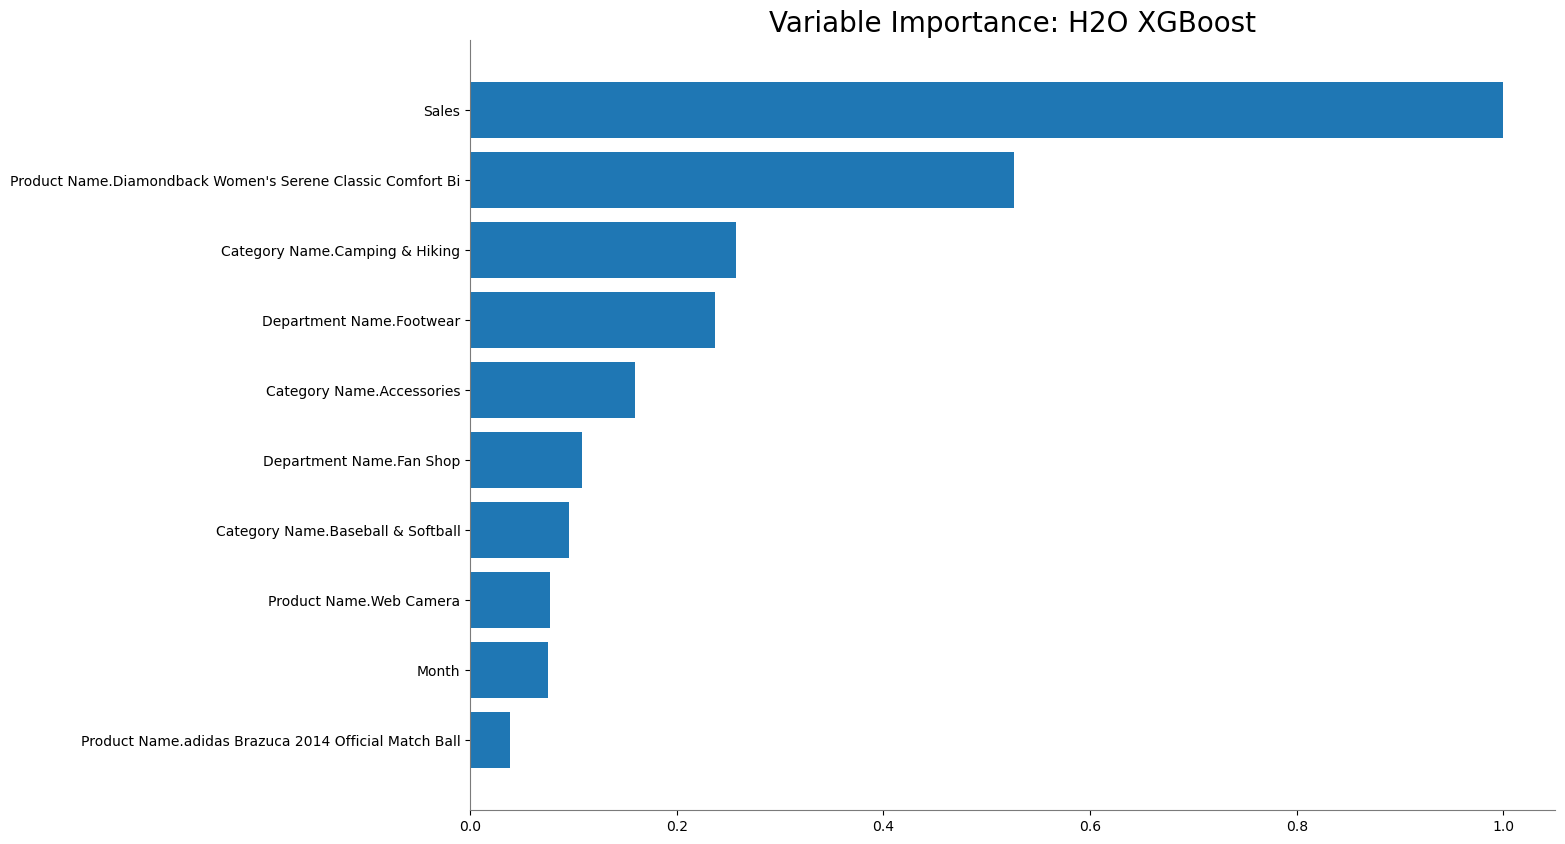

Saving figure varimp_plot


/Users/sunnygao/anaconda3/lib/python3.11/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


<Figure size 640x480 with 0 Axes>

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator
import pandas as pd
import numpy as np
import h2o
from h2o.automl import H2OAutoML
import mlflow
import mlflow.h2o
from pathlib import Path
import matplotlib.pyplot as plt

# Function definitions for data loading, saving, and plotting
DATA_PATH = Path() / "../final_project/data"
DATA_PATH.mkdir(parents=True, exist_ok=True)

def load_csv(filename, data_path=DATA_PATH, encoding='ISO-8859-1'):
    csv_path = data_path / filename
    return pd.read_csv(csv_path, encoding=encoding)

def save_csv(data, filename, data_path=DATA_PATH, encoding='ISO-8859-1'):
    csv_path = data_path / filename
    data.to_csv(csv_path, index=False, encoding=encoding)

PLOT_PATH = Path() / "../final_project/plot"
PLOT_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300, transparent=True):
    path = PLOT_PATH / f"{fig_id}.{fig_extension}"
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution, transparent=transparent)

RESULT_PATH = Path() / "../final_project/result"
RESULT_PATH.mkdir(parents=True, exist_ok=True)

def save_result(data, filename, data_path=RESULT_PATH):
    csv_path = data_path / filename
    data.to_csv(csv_path, index=False, encoding='utf-8-sig')

MODEL_PATH = Path() / "../final_project/models"
MODEL_PATH.mkdir(parents=True, exist_ok=True)

def save_h2o_model(model, filename, model_path=MODEL_PATH):
    full_path = model_path / filename
    full_path.parent.mkdir(parents=True, exist_ok=True)
    saved_model_path = h2o.save_model(model=model, path=str(full_path.parent), force=True)
    print(f"Model saved to: {saved_model_path}")
    return saved_model_path

# Custom transformer for reading data
class DataReader(BaseEstimator, TransformerMixin):
    def __init__(self, filename):
        self.filename = filename
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return pd.read_csv(self.filename, encoding='ISO-8859-1')

# Custom transformer for cleaning data
class DataCleaner(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_clean = X.drop(columns=['Days for shipping (real)', 'Delivery Status', 'Late_delivery_risk', 
                                  'shipping date (DateOrders)', 'Benefit per order', 'Sales per customer', 'Category Id',
                                  'Order Profit Per Order', 'Order Item Discount', 'Order Item Total', 'Order Status', 
                                  'Customer Email', 'Customer Password', 'Latitude', 'Longitude', 'Product Description', 'Product Image',
                                  'Customer Fname', 'Customer Id', 'Customer Lname', 'Department Id',
                                  'Order Customer Id', 'Order Item Cardprod Id', 'Order Item Id',
                                  'Product Card Id', 'Product Category Id', 'Order Id', 'Customer Street',
                                  'Customer Zipcode', 'Order Zipcode', 'Order Item Product Price',
                                  'Product Price', 'Order Item Profit Ratio', 'Product Status'])
        X_clean['order date (DateOrders)'] = pd.to_datetime(X_clean['order date (DateOrders)'])
        X_clean['Year'] = X_clean['order date (DateOrders)'].dt.year
        X_clean['Month'] = X_clean['order date (DateOrders)'].dt.month
        X_clean.sort_values(by='order date (DateOrders)', inplace=True)
        X_clean.drop(columns=['order date (DateOrders)'], inplace=True)
        return X_clean

# Custom transformer for aggregating data
class DataAggregator(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        grouped_data = X.groupby(['Type', 'Category Name', 'Customer City', 'Customer Country',
                                  'Customer Segment', 'Customer State', 'Department Name', 'Market',
                                  'Order City', 'Order Country', 'Order Region', 'Order State',
                                  'Product Name', 'Shipping Mode', 'Year', 'Month'])
        aggregated_data = grouped_data.agg({
            'Sales': 'sum',
            'Days for shipment (scheduled)': 'mean', 
            'Order Item Discount Rate': 'mean',
            'Order Item Quantity': 'sum'
        }).reset_index()
        return aggregated_data

# Custom transformer for MLflow experiment
class MLflowExperimentTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, max_models=12, exclude_algos=["StackedEnsemble"], seed=1):
        self.max_models = max_models
        self.exclude_algos = exclude_algos
        self.seed = seed
    
    def fit(self, df):
        # Initialize H2O
        h2o.init()

        # H2O Frame
        hf_dataset = h2o.H2OFrame(df[:2000])
        train, test = hf_dataset.split_frame(ratios=[0.6], seed=1)

        # Define the target and features
        y = "Order Item Quantity"
        X = hf_dataset.columns
        X.remove(y)

        # Start MLflow experiment
        with mlflow.start_run():
            # Configure and run H2O AutoML
            h2o_aml = H2OAutoML(max_models=self.max_models, seed=self.seed, exclude_algos=self.exclude_algos, verbosity="info")
            h2o_aml.train(x=X, y=y, training_frame=train)

            # Log model
            mlflow.h2o.log_model(h2o_aml.leader, "model")

            # Now, save the model using the new function
            model_filename = "best_model_demand_forcasting"
            full_path = MODEL_PATH / model_filename
            full_path.parent.mkdir(parents=True, exist_ok=True)
            saved_model_path = h2o.save_model(model=h2o_aml.leader, path=str(full_path.parent), force=True)
            print(f"Model saved to: {saved_model_path}")

            # Logging parameters and metrics
            mlflow.log_params({
                "max_models": self.max_models,
                "exclude_algos": ",".join(self.exclude_algos),
                "seed": self.seed
            })

            # Access performance metrics from the leaderboard
            perf = h2o_aml.leader.model_performance(test)
            mlflow.log_metrics({
                "rmse": perf.rmse(),
                "mae": perf.mae(),
                "r2": perf.r2()
            })

            # Variable importance plot
            h2o_aml.leader.varimp_plot()
            save_fig("varimp_plot")

            # Log the leaderboard
            lb = h2o_aml.leaderboard.as_data_frame()
            save_result(lb, "leaderboard.csv")
            mlflow.log_artifact("leaderboard.csv")

            # End run
            mlflow.end_run()

        return self
    
    def transform(self, X):
        # Dummy transform method
        return X

# Pipeline definition
data_pipeline = Pipeline([
    ('load_data', DataReader(filename="data/DataCoSupplyChainDataset.csv")),
    ('data_cleaning', DataCleaner()),
    ('data_aggregation', DataAggregator()),
    ('mlflow_experiment', MLflowExperimentTransformer(max_models=12, exclude_algos=["StackedEnsemble"], seed=1))
])

# Load data
supplyChain = load_csv("DataCoSupplyChainDataset.csv")

# Execute the pipeline
processed_data = data_pipeline.fit_transform(supplyChain)